In [2]:
%matplotlib inline

In [3]:
from jiang_usmf import monte_carlo_subhalo_population, best_fit_param_dict
del best_fit_param_dict['chi2']

from halotools.sim_manager import CachedHaloCatalog
halocat = CachedHaloCatalog(simname='bolplanck')

from halotools.utils import SampleSelector

hosts, subs = SampleSelector.host_halo_selection(table=halocat.halo_table, return_subhalos=True)

hosts.sort('halo_mvir')
subs.sort('halo_mvir_host_halo')

log10_msub_min = 11
subhalo_mpeak_cut = 10**log10_msub_min

log10_mhost_min = max(11.5, log10_msub_min)
log10_mhost_max = np.log10(hosts['halo_mvir'].max()) + 0.01

subhalo_sample_mask = subs['halo_mpeak'] > subhalo_mpeak_cut
subhalo_sample_mask *= subs['halo_mvir_host_halo'] >= 10**log10_mhost_min
host_halo_sample_mask = hosts['halo_mvir'] > 10**log10_mhost_min

hosts = hosts[host_halo_sample_mask]
subs = subs[subhalo_sample_mask]

In [4]:
num_mhost_bins = 25
mhost_bin_edges = np.logspace(log10_mhost_min, log10_mhost_max, num_mhost_bins)
log10_mhost_bin_mids = 0.5*(np.log10(mhost_bin_edges[:-1]) + np.log10(mhost_bin_edges[1:]))
mhost_bin_mids = 10**log10_mhost_bin_mids

In [5]:
import jiang_usmf
reload(jiang_usmf)

mc_nsub, mc_subhalo_mpeak = jiang_usmf.monte_carlo_subhalo_population(hosts['halo_mvir'], 
                                                           log10_msub_min, 
                                                           np.log10(mhost_bin_edges), **best_fit_param_dict)
mhost_mock = np.append(hosts['halo_mvir'], np.repeat(hosts['halo_mvir'], mc_nsub))

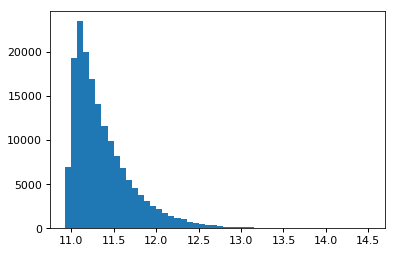

In [6]:
fig, ax = plt.subplots(1, 1)

__=ax.hist(np.log10(mc_subhalo_mpeak), bins=50)

In [7]:
from halotools.empirical_models import Behroozi10SmHm
model = Behroozi10SmHm(redshift=0)

In [25]:
sm_centrals = model.mc_stellar_mass(prim_haloprop=hosts['halo_mpeak'])
sm_satellites = model.mc_stellar_mass(prim_haloprop=mc_subhalo_mpeak)
sm_mock = np.append(sm_centrals, sm_satellites)

mpeak_mock = np.append(hosts['halo_mpeak'], mc_subhalo_mpeak)

In [26]:
from halotools.empirical_models import PrebuiltSubhaloModelFactory
beh_model = PrebuiltSubhaloModelFactory('behroozi10', redshift=0)
beh_model.populate_mock(halocat)

mask = beh_model.mock.galaxy_table['halo_mvir_host_halo'] > 10**log10_mhost_min
mask *= (beh_model.mock.galaxy_table['halo_mpeak'] > subhalo_mpeak_cut)
sample = beh_model.mock.galaxy_table[mask]

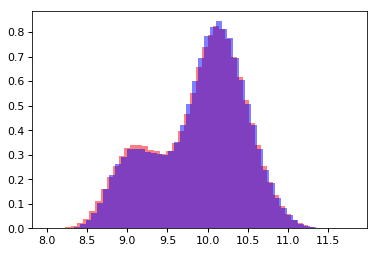

In [27]:
fig, ax = plt.subplots(1, 1)

__=ax.hist(np.log10(sm_mock), bins=50, normed=True, color='red', alpha=0.5)
__=ax.hist(np.log10(sample['stellar_mass']), bins=50, normed=True, color='blue', alpha=0.5)

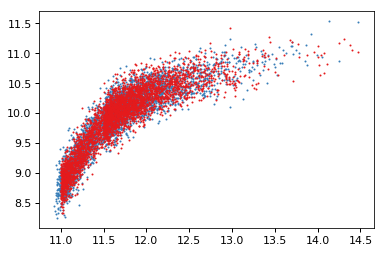

In [36]:
fig, ax = plt.subplots(1, 1)

__=ax.scatter(np.log10(mpeak_mock[::100]), np.log10(sm_mock[::100]), 
              s=1, color=blue)
__=ax.scatter(np.log10(sample['halo_mpeak'][::100]), np.log10(sample['stellar_mass'][::100]), 
              s=1, color=red)